# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [8]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""
    
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).

    time = np.array(time)
    voltage = np.array(voltage)

    threshold = 0.5 * (np.max(voltage) + np.min(voltage))

    # 2. Boolean mask: True while peak is high
    high = voltage > threshold

    # 3. Find rising and falling edges of the high regions
    edges = np.diff(high.astype(int))

    start_indices = np.where(edges == +1)[0] + 1   # rising edges
    end_indices   = np.where(edges == -1)[0]       # falling edges

    # Handle case where signal starts or ends high
    if high[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if high[-1]:
        end_indices = np.append(end_indices, len(high)-1)

    # 4. Compute center times for each peak
    peak_centers = (time[start_indices] + time[end_indices]) / 2
   

    t_pass = np.array(peak_centers)
    t_pass_sigma = np.full_like(t_pass, 0.00001)    
    if show_plot:
        plt.plot(time, voltage, label='Voltage signal')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.xlim(time[0], .6)
        plt.title('Ball on Incline Voltage Signal with Detected Passings')
        plt.legend()
        plt.show()
    


    
    return t_pass, t_pass_sigma

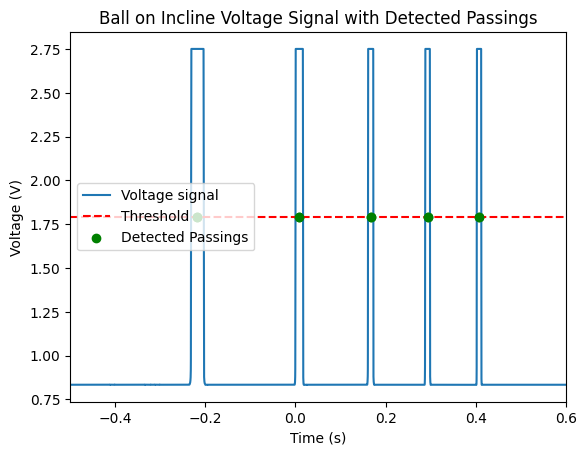

In [9]:
# Read the data and plot it (possibly with passing times in):
filename = 'ball_big_1.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

# fig, ax = plt.subplots(figsize=(14, 6))
# ax.plot(time, voltage, 'k.', label='Measurements')
# ax.set_title("Data from Ball-on-Incline experiment")
# ax.set_xlabel("Time (s)", fontsize=18)
# ax.set_ylabel("Voltage (V)", fontsize=18)


In [16]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import numpy as np
from scipy import stats

In [ ]:
def model(t, a, v0):
    return 0.5 * a * t**2 + v0 * t
def fit(weighted_mean, weighted_mean_err, timepass):
  
    x = weighted_mean
    t = timepass - timepass[0]  # set t=0 at first passing

    sx = weighted_mean_err

    mfit = Minuit(LeastSquares(t, x, sx, model), a=9.81, v0=0.0)
    mfit.migrad()  # perform the minimization
    return mfit




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1225 (χ²/ndof = 0.0)     │              Nfcn = 37               │
│ EDM = 2.14e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.09    │            │            │         │         │       │
│ 1 │ v0   │   0.332   │   0.025   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        a       v0 │
├────┼───────────────────┤
│  a │  0.00876  -2.3e-3 │
│ v0 │  -2.3e-3 0.000631 │
└────┴───────────────────┘

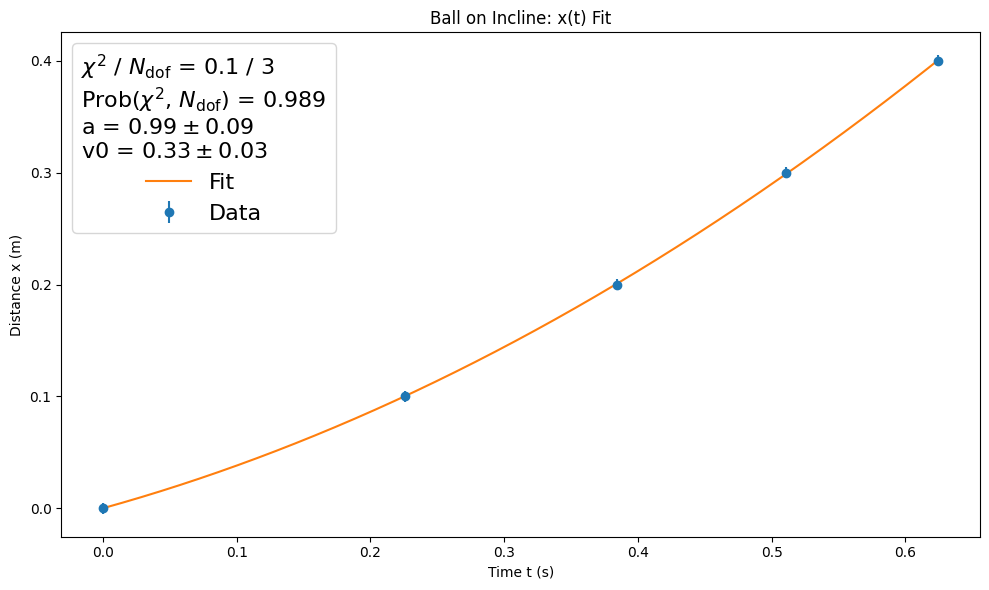

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with uncertainties in x
ax.errorbar(t, x, xerr=None, yerr=sx, fmt='o', label='Data')

ax.set(
    xlabel='Time t (s)',
    ylabel='Distance x (m)',
    title='Ball on Incline: x(t) Fit'
)

# Plot fit curve
t_fit = np.linspace(min(t), max(t), 1000)
x_fit = model(t_fit, *mfit.values)
ax.plot(t_fit, x_fit, '-', label='Fit')


# ------------------------------
# 4. CHI-SQUARE + p-value
# ------------------------------
chi2 = mfit.fval                          # χ² = cost function minimum value
Ndof = len(x) - len(mfit.values)          # number of degrees of freedom
p_value = stats.chi2.sf(chi2, Ndof)          # survival function

fit_info = [
    rf"$\chi^2$ / $N_\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}",
    rf"Prob($\chi^2$, $N_\mathrm{{dof}}$) = {p_value:.3f}",
]

# Parameters + uncertainties
for p, v, e in zip(mfit.parameters, mfit.values, mfit.errors):
    Ndec = max(0, -int(np.log10(e) - 1 - np.log10(2)))
    fit_info.append(
        f"{p} = ${v:{10}.{Ndec}f} \\pm {e:{10}.{Ndec}f}$"
    )

plt.legend(title="\n".join(fit_info),
           fontsize=16,
           title_fontsize=16,
           alignment='center')

fig.tight_layout()
plt.show()

In [ ]:
def main(filename):
    weighted_mean = np.array([8.45567020250723,23.390549662487942,38.54252651880424 ,53.46890067502411,69.1189006750241  ])*0.01
    weighted_mean_err = np.array([0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758])*0.01
    time, voltage = read_csv(filename)
    timepass, timepass_sig = find_midpoints(time, voltage)

    mfit = fit(weighted_mean, weighted_mean_err, timepass)
    return mfit


# What to do next?

From the V(t) data you should be able to determine five times at which the ball passed. Discuss in the group how to do this best, and possibly test it by seeing if the result is "invariant" between different data sets.

Note that getting an uncertainty can be hard, and think about the relevance of such an uncertainty, which should anyway be rather small.